In [331]:
import pandas as pd

In [332]:
raw = pd.read_csv('BT-Picks.csv', header=None)
raw.columns = ["date", "day", "pick", "secondary_pick"]
raw = raw.drop(columns='secondary_pick')
raw.head()

,date,day,pick
0,12/1/20,Tuesday,Eagle Rare
1,12/2/20,Wednesday,E.H. Taylor Jr. Small Batch
2,12/3/20,Thursday,Blanton’s
3,12/4/20,Friday,Single Oak Project
4,12/5/20,Saturday,Eagle Rare


In [333]:
#Converting the date column to numeric and creating new features

# Convert 'date' column to datetime using pd.to_datetime()
raw['date'] = pd.to_datetime(raw['date'])

# Create a 'week' column using the isocalendar week method
raw['week'] = raw['date'].dt.isocalendar().week

# Corrected: use .dt.month to get the month
raw['month'] = raw['date'].dt.month

# Create a 'year' column using the isocalendar year method
raw['year'] = raw['date'].dt.isocalendar().year

# Corrected: use 'date' instead of 'date_column'
raw['day'] = raw['date'].dt.day
raw['day_of_week'] = raw['date'].dt.dayofweek


# Display the first few rows
raw.head()


/var/folders/wb/stch18dn2z1gw9s72md26f740000gn/T/ipykernel_91693/2786939293.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  raw['date'] = pd.to_datetime(raw['date'])


,date,day,pick,week,month,year,day_of_week
0,2020-12-01,1,Eagle Rare,49,12,2020,1
1,2020-12-02,2,E.H. Taylor Jr. Small Batch,49,12,2020,2
2,2020-12-03,3,Blanton’s,49,12,2020,3
3,2020-12-04,4,Single Oak Project,49,12,2020,4
4,2020-12-05,5,Eagle Rare,49,12,2020,5


In [334]:
#I need to make sure that the arent duplicate names for each of the picks before doing one hot encoding
raw['pick'].value_counts()



pick
Blanton’s                       388
W.L. Weller Special Reserve     336
E.H. Taylor, Jr. Small Batch    309
Eagle Rare                      280
Sazerac Rye                      46
Closed                           13
CLOSED                           10
E.H. Taylor Jr. Small Batch       7
Single Oak Project                6
Weller Special Reserve            5
Closed – Holiday                  3
Name: count, dtype: int64

In [336]:
#problem names: CLOSED -> Closed, E.H. Taylor Jr. Small Batch -> E.H. Taylor, Jr. Small Batch, Weller Special Reserve -> W.L. Weller Special Reserve, Closed – Holiday -> Closed

# Replacement dictionary
replace_dict = {
    'CLOSED': 'Closed',
    'E.H. Taylor Jr. Small Batch': 'E.H. Taylor, Jr. Small Batch',
    'Weller Special Reserve': 'W.L. Weller Special Reserve',
    'Closed – Holiday': 'Closed',
    "Blanton's": 'Blantons'  # This is the key to check
}

# Ensure all values in the 'pick' column are strings and strip any spaces
raw['pick'] = raw['pick'].astype(str).str.strip()

# Replace values in the 'pick' column
raw['pick'] = raw['pick'].replace(replace_dict)

# Display the value counts to check the results
print(raw['pick'].value_counts())

#looks alot better

pick
Blanton’s                       388
W.L. Weller Special Reserve     341
E.H. Taylor, Jr. Small Batch    316
Eagle Rare                      280
Sazerac Rye                      46
Closed                           26
Single Oak Project                6
nan                               2
Name: count, dtype: int64


In [328]:
# They no longer give out Sazerac Rye or the One Oak Project out as allocations. 
# We need to count the number of rows that have these values and we need to get rid of them.

not_allocated_anymore = raw['pick'].isin(['Single Oak Project', 'Sazerac Rye']).sum()
print(f"Number of rows with 'Single Oak Project' or 'Sazerac Rye' in picks: {not_allocated_anymore}")


Number of rows with 'Single Oak Project' or 'Sazerac Rye' in picks: 52


In [327]:
#Creating a new column that only contains past allocations that align with current allocations
allocation_data = raw[~raw['pick'].isin(['Single Oak Project', 'Sazerac Rye'])]
allocation_data['pick'].value_counts()

pick
Blanton’s                       388
W.L. Weller Special Reserve     341
E.H. Taylor, Jr. Small Batch    316
Eagle Rare                      280
Closed                           26
Name: count, dtype: int64

In [318]:
# Need to look at all of the dates that correspond to the store closing as this will change the predicitions
# We need to find patterns to which holidays the store is closed so that we can update the model to predict that in future dates

closed_dates = allocation_data[allocation_data['pick']=='Closed']

# Extract day of the week and month
closed_dates['day_of_week'] = closed_dates['date'].dt.day_name()
closed_dates['month'] = closed_dates['date'].dt.month_name()

closed_dates[['date', 'day_of_week', 'month']]

/var/folders/wb/stch18dn2z1gw9s72md26f740000gn/T/ipykernel_91693/1976851407.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  closed_dates['day_of_week'] = closed_dates['date'].dt.day_name()
/var/folders/wb/stch18dn2z1gw9s72md26f740000gn/T/ipykernel_91693/1976851407.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  closed_dates['month'] = closed_dates['date'].dt.month_name()


,date,day_of_week,month
24,2020-12-25,Friday,December
31,2021-01-01,Friday,January
91,2021-03-02,Tuesday,March
92,2021-03-03,Wednesday,March
93,2021-03-04,Thursday,March
94,2021-03-05,Friday,March
95,2021-03-06,Saturday,March
96,2021-03-07,Sunday,March
117,2021-03-28,Sunday,March
124,2021-04-04,Sunday,April


Holidays that they have been closed: 

- Thanksgiving
- Christmas
- July 4th
- Easter
- New Years

Random Days: 

-3/28/21
-2/4/22
-12/23/24 (could have had an extended christmas closure)

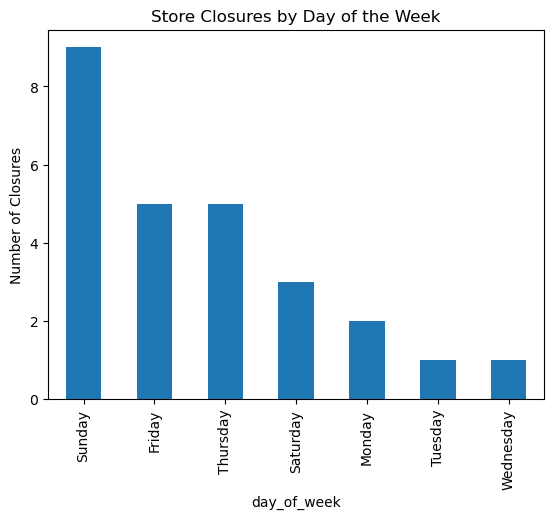

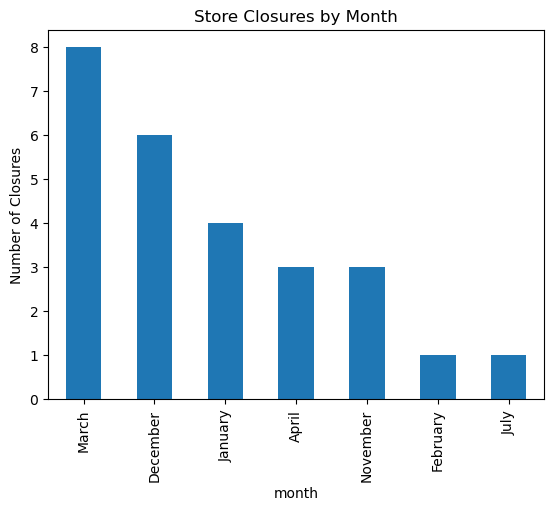

In [319]:
import matplotlib.pyplot as plt

# Count closures by day of the week
closure_pattern_by_day = closed_dates['day_of_week'].value_counts()

# Count closures by month
closure_pattern_by_month = closed_dates['month'].value_counts()


# Bar chart for closures by day of the week
closure_pattern_by_day.plot(kind='bar', title='Store Closures by Day of the Week')
plt.ylabel('Number of Closures')
plt.show()

# Bar chart for closures by month
closure_pattern_by_month.plot(kind='bar', title='Store Closures by Month')
plt.ylabel('Number of Closures')
plt.show()

In [320]:
model_data = allocation_data[allocation_data['pick'] != "Closed"]
model_data['pick'].value_counts()

pick
Blanton’s                       388
W.L. Weller Special Reserve     341
E.H. Taylor, Jr. Small Batch    316
Eagle Rare                      280
Name: count, dtype: int64

In [321]:
#Droping date as this cannot be used in the model

model_data = model_data.drop(columns =['date'])
model_data.head()

,day,pick,week,month,year,day_of_week
0,1,Eagle Rare,49,12,2020,1
1,2,"E.H. Taylor, Jr. Small Batch",49,12,2020,2
2,3,Blanton’s,49,12,2020,3
4,5,Eagle Rare,49,12,2020,5
5,6,Blanton’s,49,12,2020,6


In [322]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


In [326]:
# One hot encoding
# One-hot encoding the target variable
one_hot_encoded_target = pd.get_dummies(model_data['pick'], prefix='class')

# Combine the one-hot encoded columns with the original DataFrame if needed
encoded = pd.concat([model_data, one_hot_encoded_target], axis=1)
encoded.head()

,day,pick,week,month,year,day_of_week,class_Blanton’s,"class_E.H. Taylor, Jr. Small Batch",class_Eagle Rare,class_W.L. Weller Special Reserve
0,1,Eagle Rare,49,12,2020,1,False,False,True,False
1,2,"E.H. Taylor, Jr. Small Batch",49,12,2020,2,False,True,False,False
2,3,Blanton’s,49,12,2020,3,True,False,False,False
4,5,Eagle Rare,49,12,2020,5,False,False,True,False
5,6,Blanton’s,49,12,2020,6,True,False,False,False


In [324]:
# Step 1: Create y by converting one-hot encoded classes to a single label
y = encoded[['class_Blanton's', 'class_E.H. Taylor, Jr. Small Batch', 'class_C']].idxmax(axis=1)

# Step 2: Create X by dropping the one-hot encoded class columns
X = encoded.drop(columns=['class_A', 'class_B', 'class_C'])



SyntaxError: unterminated string literal (detected at line 2) (1862457391.py, line 2)

In [ ]:
y.head()
#X.head()

,target_Blanton’s,"target_E.H. Taylor, Jr. Small Batch",target_Eagle Rare,target_W.L. Weller Special Reserve
0,False,False,True,False
1,False,True,False,False
2,True,False,False,False
4,False,False,True,False
5,True,False,False,False


In [ ]:
# Initialize a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Perform cross-validation (for multi-class classification)
cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='accuracy')

# Print cross-validation scores and mean accuracy
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation accuracy:", cv_scores.mean())


Cross-validation scores: [1. 1. 1. 1. 1.]
Mean cross-validation accuracy: 1.0
